# Imports

In [230]:
import cv2
import imageio.v3 as iio
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import time

# Global constants

In [231]:
TOTAL_FRAMES = 20
TOTAL_DISPLAY_FRAMES = 1

# Colors for matplotlib plots 
DETECTOR_COLORS_MPL = {
    "orb": 'green',
    "sift": 'blue',
    "fast": 'red',
    "shi_tomasi": 'cyan',
    "harris": 'magenta'
}

DETECTOR_COLORS = {
    "ORB": (0, 255, 0),          
    "SIFT": (255, 0, 0),         
    "FAST": (0, 0, 255),         
    "Shi-Tomasi": (255, 255, 0), 
    "Harris": (255, 0, 255)      
}

# 1. Video Acquisition  

# 2. Frame Extraction

In [232]:
def get_frame_indices(video_path:str, num_frames:int) -> list:
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    if num_frames > total_frames:
        raise ValueError(f"Requested {num_frames} frames, but video has only {total_frames} frames.")

    # Compute evenly spaced indices
    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    return indices.tolist()

def load_specific_frames(video_path:str, selected_indices:list, display_frames=True) -> list:
    frames = []
    selected_set = set(selected_indices)
    frame_count = 0

    try:
        for frame in iio.imiter(video_path):
            if frame_count in selected_set:
                frames.append(frame)

                if display_frames:
                    plt.imshow(frame)
                    plt.title(f'Frame {frame_count}')
                    plt.axis('off')
                    plt.show()

            frame_count += 1

    except FileNotFoundError:
        print(f"Error: Video file not found at {video_path}")
        return []
    except Exception as e:
        print(f"An error occurred while processing the video: {e}")
        return []

    print(f"\nFinished loading selected frames.")
    print(f"Total frames processed: {frame_count}")
    
    return frames

In [233]:
video_path = "../videos/vid4.mp4"
indices = get_frame_indices(video_path, TOTAL_FRAMES)
frames = load_specific_frames(video_path, selected_indices=indices, display_frames=False)
pair_indices = list(range(len(frames) - 1))  # Pairs: (0,1), (1,2), ..., (n-2, n-1)

#NOTE -2, since first want to access up to the penultimate entry 
display_indices = np.linspace(0, len(frames) - 2, num=TOTAL_DISPLAY_FRAMES, dtype=int)

The frame size for reading (480, 848) is different from the source frame size (848, 480).



Finished loading selected frames.
Total frames processed: 353


# 3. Feature Detection and Description

## Models

In [234]:
def detect_orb(gray):
    orb = cv2.ORB_create(nfeatures=3000)
    return orb.detect(gray, None)

def detect_sift(gray):
    sift = cv2.SIFT_create(nfeatures=3000, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    keypoints, _ = sift.detectAndCompute(gray, None)
    return keypoints

def detect_fast(gray):
    fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
    return fast.detect(gray, None)

def detect_shi_tomasi(gray):
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=3000, qualityLevel=0.01, minDistance=10, blockSize=3)
    if corners is not None:
        return [cv2.KeyPoint(float(x), float(y), 1) for [[x, y]] in corners]
    return []

def detect_harris(gray, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01):
    gray_f32 = np.float32(gray)
    dst = cv2.cornerHarris(gray_f32, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    threshold = threshold_ratio * dst.max()
    corners = np.argwhere(dst > threshold)
    return [cv2.KeyPoint(float(pt[1]), float(pt[0]), 1) for pt in corners]


## Visualization

In [235]:
def run_feature_detector_pairs(frames, display_frame_indices, pair_indices, detector_fn, detector_name, title_prefix="Detector"):
    #pair_indices = list(pair_indices)  # Ensure it's a list, not a numpy array

    if len(frames) < 2:
        print("Error: At least two frames are necessary.")
        return

    max_index = len(frames) - 2
    invalid_indices = [i for i in pair_indices if i < 0 or i > max_index]
    if invalid_indices:
        print(f"Error: Invalid indices found: {invalid_indices}. Must be in range 0 to {max_index}.")
        return
    
    color = DETECTOR_COLORS.get(detector_name, (0, 255, 0)) # Default to green if name not found

    for display_idx, i in enumerate(display_frame_indices, 1): # Iterate through the *chosen* pairs
        j = i + 1
        img1 = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

        keypoints1 = detector_fn(img1)
        keypoints2 = detector_fn(img2)
        
        img_kp1 = cv2.drawKeypoints(img1, keypoints1, None, color=color)
        img_kp2 = cv2.drawKeypoints(img2, keypoints2, None, color=color)

        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        axes[0].imshow(img_kp1, cmap='gray')
        axes[0].set_title(f"{title_prefix} - Frame {i}, Keypoints:{len(keypoints1)}")
        axes[1].imshow(img_kp2, cmap='gray')
        axes[1].set_title(f"{title_prefix} - Frame {j}, Keypoints:{len(keypoints2)}")

        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(f"{title_prefix} Comparison: Pair {display_idx}, Frame {i} and Frame {j}")
        plt.tight_layout()
        plt.show()

### ORB

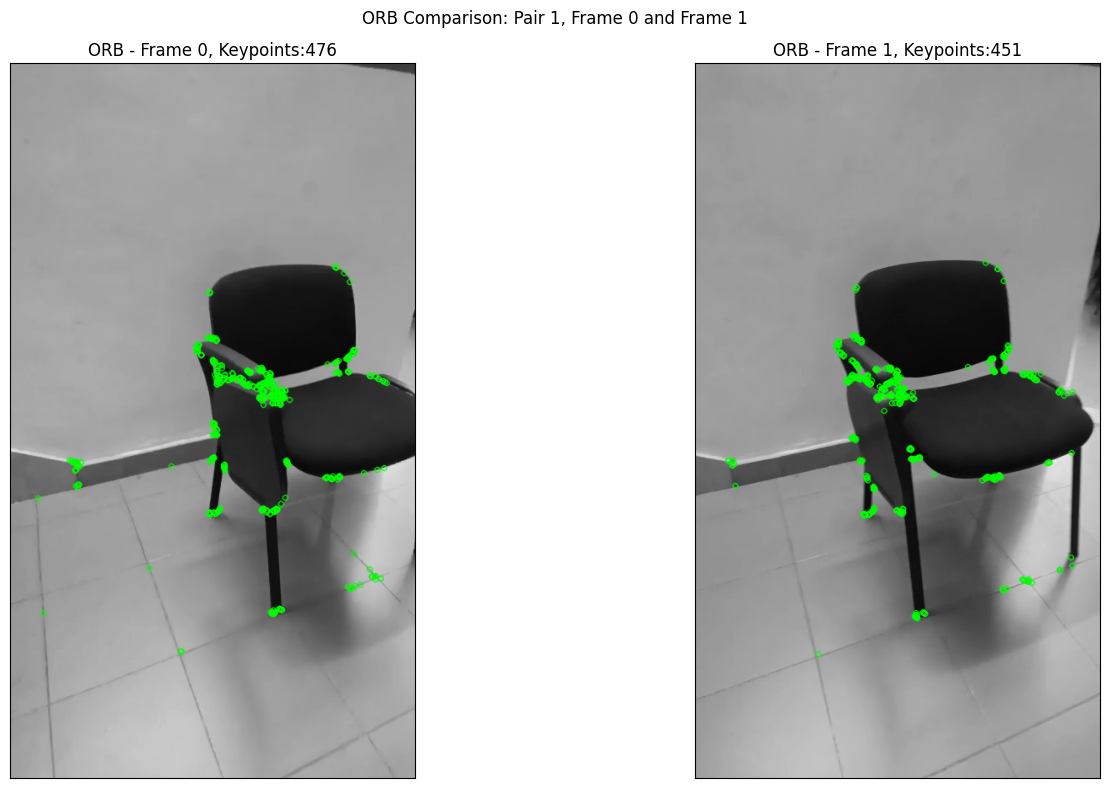

In [236]:
run_feature_detector_pairs(frames, display_indices, pair_indices, detect_orb, "ORB",title_prefix="ORB")

### SIFT

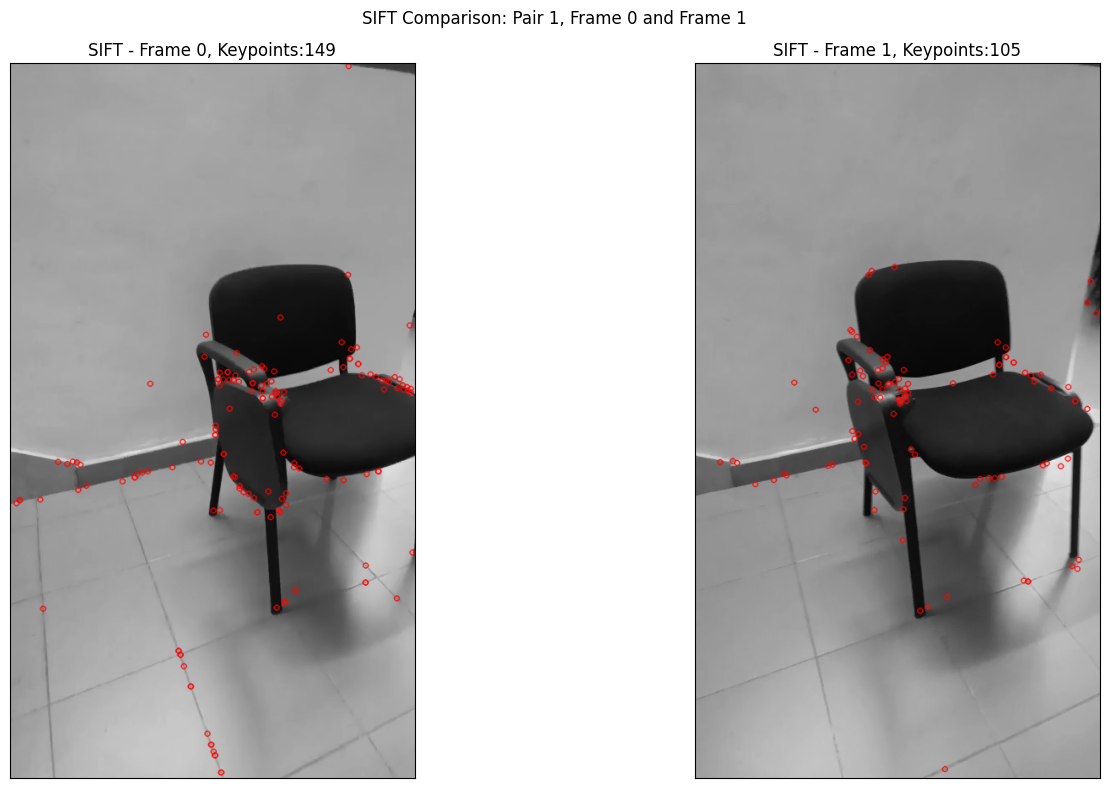

In [237]:
run_feature_detector_pairs(frames, display_indices, pair_indices, detect_sift,"SIFT",  title_prefix="SIFT")

### FAST

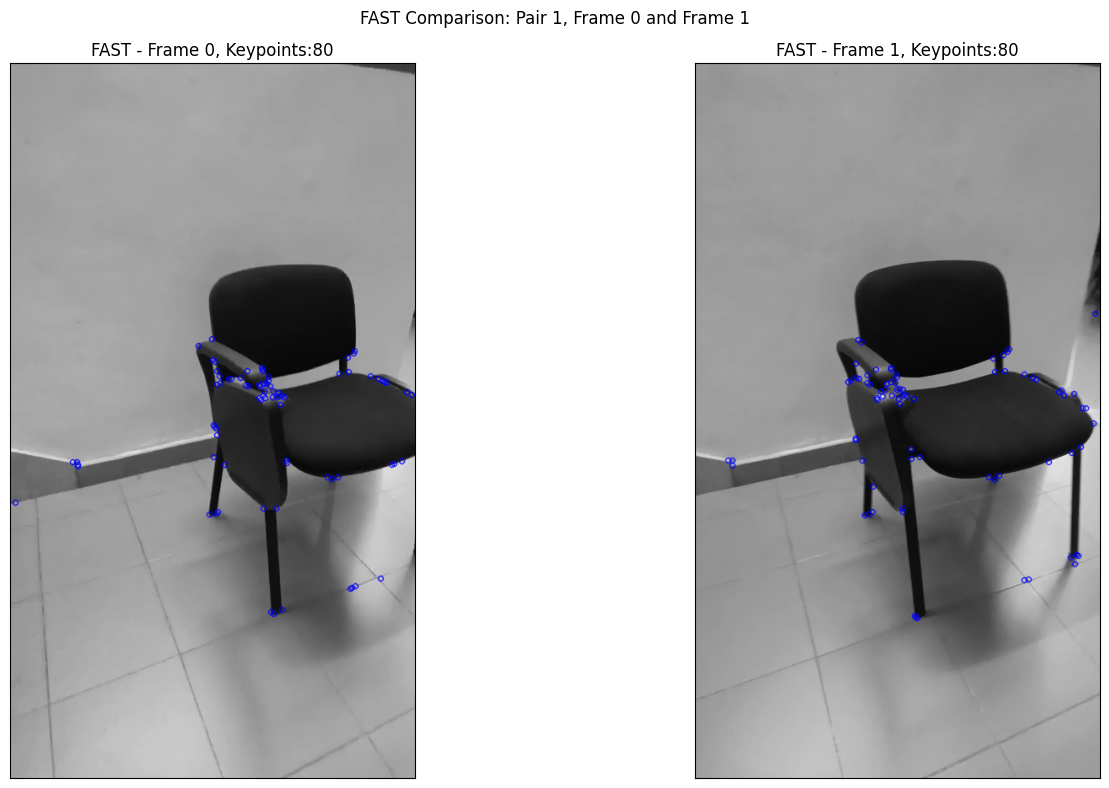

In [238]:
run_feature_detector_pairs(frames, display_indices, pair_indices, detect_fast, "FAST", title_prefix="FAST")

### SHI-TOMASI

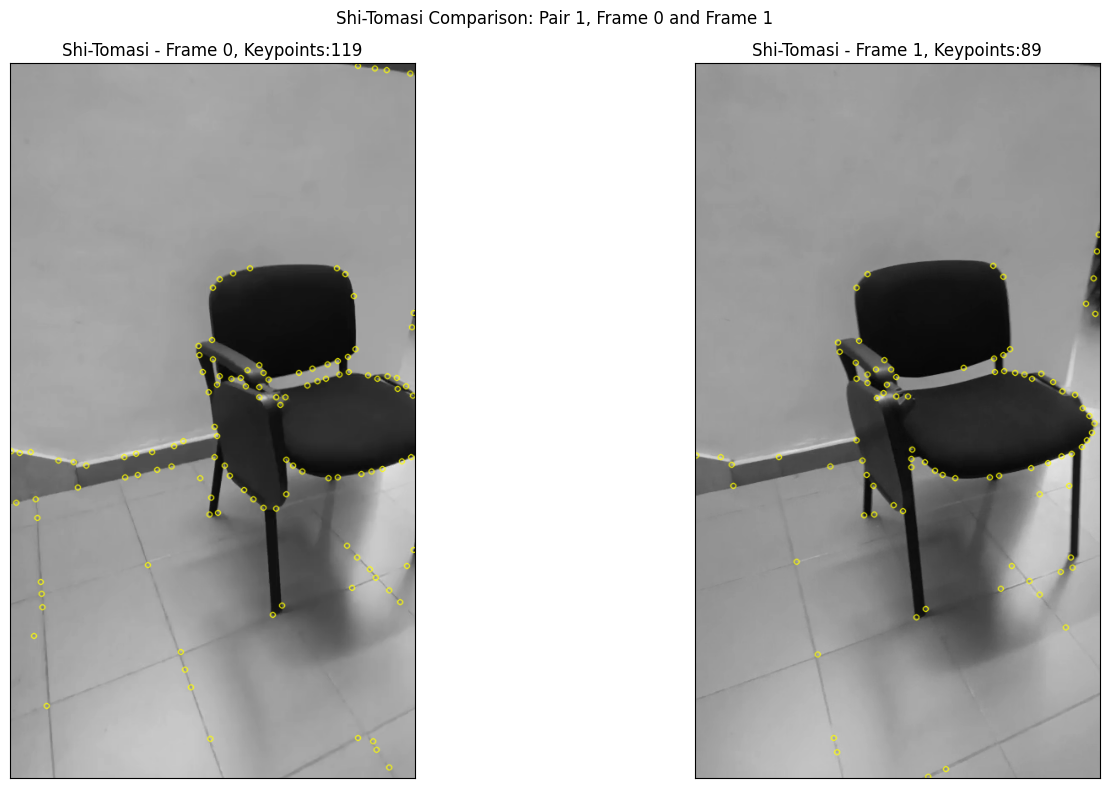

In [239]:
run_feature_detector_pairs(frames, display_indices, pair_indices, detect_shi_tomasi, "Shi-Tomasi", title_prefix="Shi-Tomasi")

### Harris

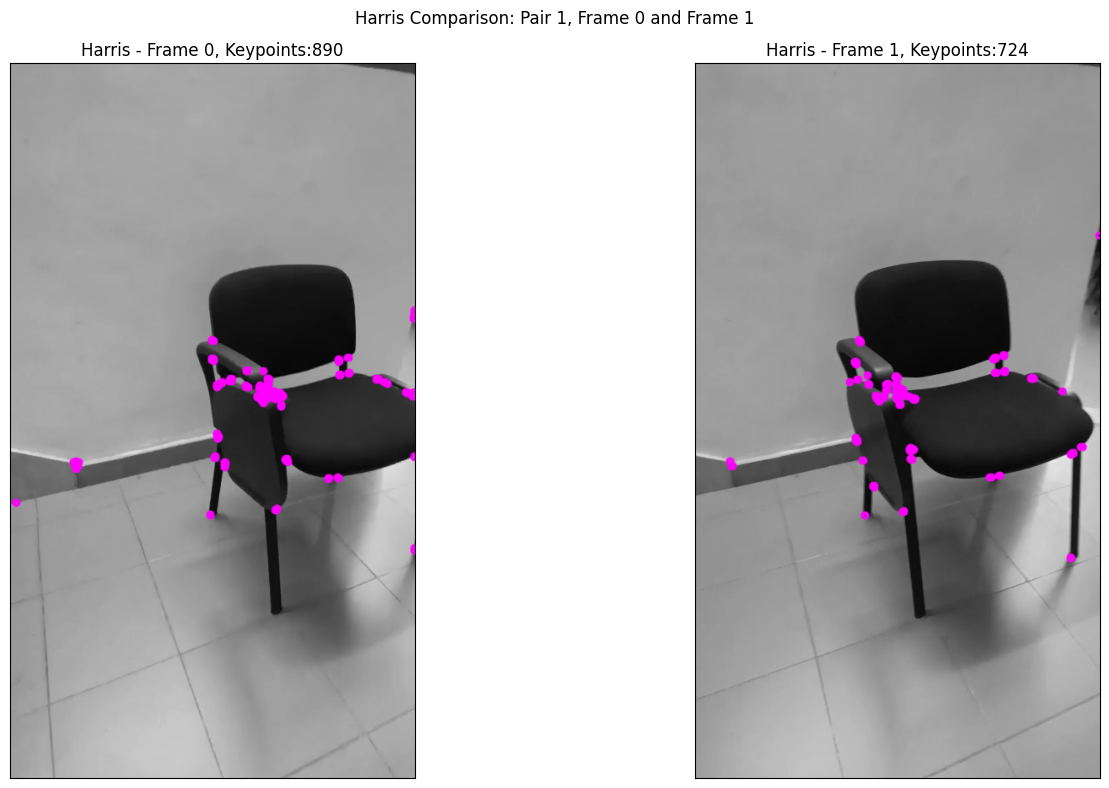

In [240]:
run_feature_detector_pairs(frames, display_indices, pair_indices, detect_harris, "Harris", title_prefix="Harris")

## Combined Comparison

In [241]:
def plot_keypoints_and_times(results):
    indices = results['frame_indices']

    # Keypoints
    plt.figure(figsize=(12, 6))
    for name, data in results.items():
        if name != 'frame_indices':
            color = DETECTOR_COLORS_MPL.get(name, 'green')
            plt.plot(indices, data['keypoint_counts'], label=f'{name.upper()} Keypoints', color=color)
    plt.title("Keypoints per Frame")
    plt.xlabel("Frame Number")
    plt.ylabel("Number of Keypoints")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Computation time
    plt.figure(figsize=(12, 6))
    for name, data in results.items():
        if name != 'frame_indices':
            color = DETECTOR_COLORS_MPL.get(name, 'green')
            plt.plot(indices, data['computation_times'], label=f'{name.upper()} Time', color=color)
    plt.title("Computation Time per Frame")
    plt.xlabel("Frame Number")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print averages
    for name, data in results.items():
        if name != 'frame_indices':
            print(f"Average {name.upper()}: {np.mean(data['keypoint_counts']):.1f} keypoints, {np.mean(data['computation_times']):.4f}s")


In [242]:
def compare_detectors_per_frame(frames, frame_indices):
    detectors = {
        "ORB": detect_orb,
        "SIFT": detect_sift,
        "FAST": detect_fast,
        "Shi-Tomasi": detect_shi_tomasi,
        "Harris": detect_harris
    }

    for idx in frame_indices:
        if idx < 0 or idx >= len(frames):
            print(f"Skipping invalid frame index {idx}")
            continue

        gray = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2GRAY)
        frame_results = {}

        for name, fn in detectors.items():
            keypoints = fn(gray)
            color = DETECTOR_COLORS.get(name, (0, 255, 0))  # default green if missing
            img_with_kp = cv2.drawKeypoints(frames[idx], keypoints, None, color)
            frame_results[name] = (img_with_kp, len(keypoints))

        # Plot all detector results in 3x3 grid
        fig, axes = plt.subplots(2, 3, figsize=(15, 15))

        # Flatten axes for easy iteration
        axes = axes.flatten()

        # Plot the 5 detector images
        for ax, (name, (img, count)) in zip(axes, frame_results.items()):
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{name} ({count})")
            ax.axis('off')

        # Hide the remaining axes (empty slots)
        for ax in axes[len(frame_results):]:
            ax.axis('off')

        plt.suptitle(f"Detector Comparison - Frame {idx}", fontsize=16)
        plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.05, hspace=0.1)
        plt.show()

def benchmark_detectors(frames):
    detectors = {
        "orb": detect_orb,
        "sift": detect_sift,
        "fast": detect_fast,
        "shi_tomasi": detect_shi_tomasi,
        "harris": detect_harris
    }

    results = {name: {'keypoint_counts': [], 'computation_times': []} for name in detectors}
    results['frame_indices'] = list(range(len(frames)))

    for i, frame in enumerate(frames):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        for name, detector_fn in detectors.items():
            start = time.time()
            keypoints = detector_fn(gray)
            elapsed = time.time() - start

            results[name]['keypoint_counts'].append(len(keypoints))
            results[name]['computation_times'].append(elapsed)

    plot_keypoints_and_times(results)
    return results

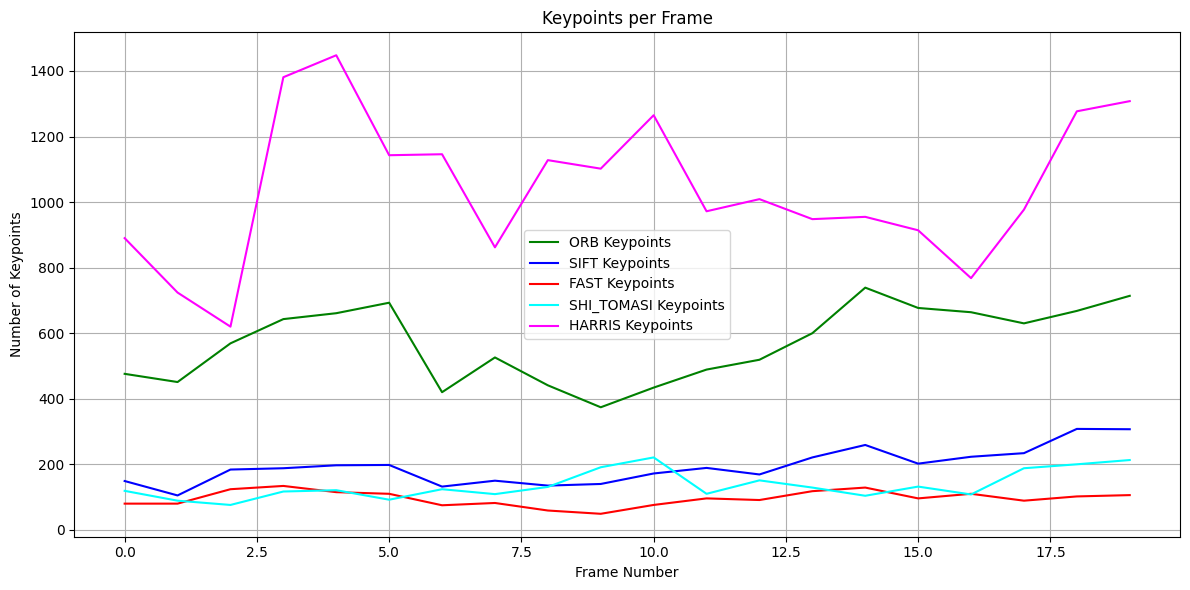

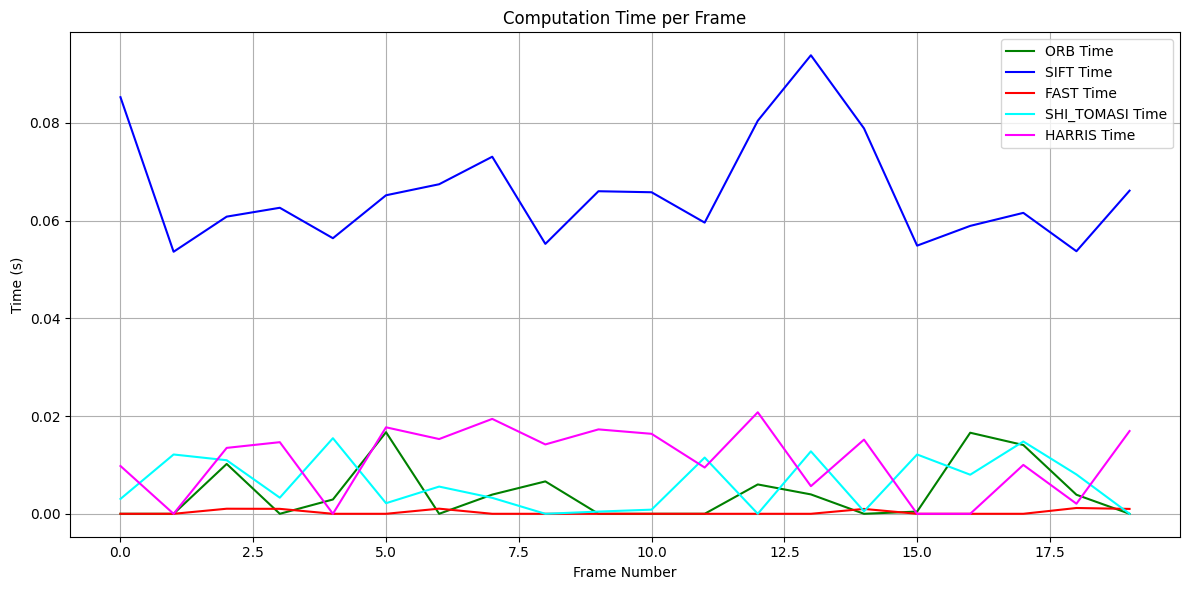

Average ORB: 569.4 keypoints, 0.0043s
Average SIFT: 193.1 keypoints, 0.0660s
Average FAST: 96.0 keypoints, 0.0003s
Average SHI_TOMASI: 136.2 keypoints, 0.0062s
Average HARRIS: 1041.8 keypoints, 0.0109s


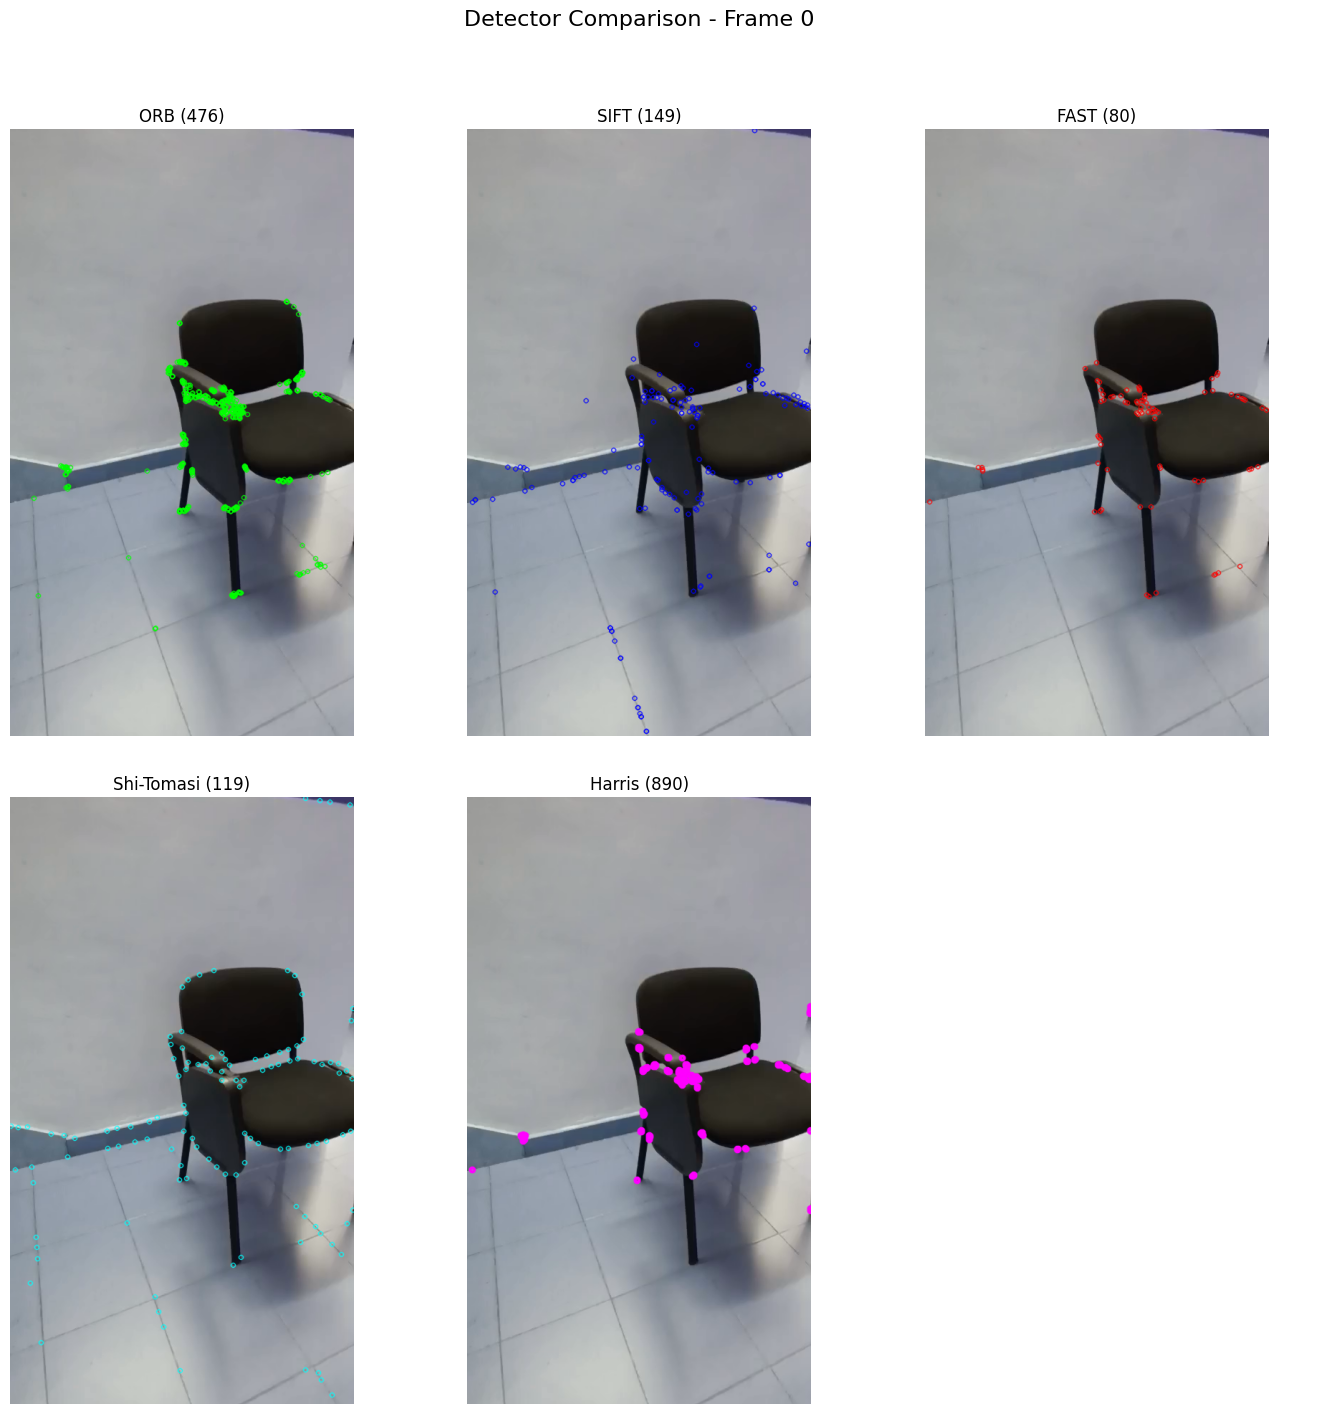

In [243]:
benchmark_results = benchmark_detectors(frames)
compare_detectors_per_frame(frames, frame_indices=display_indices)

# 4. Feature Matching and Outlier Rejection 

# 5. Essential/Fundamental Matrix Computation 

# 6. Camera Pose Estimation

# 7. 3D Point Triangulation and Scene Visualisation 

# 8.Evaluation and Analysis 